In [15]:
%matplotlib inline
import re
import io
import urllib2
import networkx as nx
import json
import glob
import numpy as np
import operator
import matplotlib.pyplot as plt
import time
from __future__ import division
from pprint import pprint
import community


In [2]:
def getJSONReply(URL):
    response = urllib2.urlopen(URL);
    html = response.read();
    data = json.loads(html);
    return data;


def getUserInput():
    FileExists=os.path.isfile('RitoMongo.conf') ;
    res=[];
    if (FileExists):
        with open('RitoMongo.conf') as f:
            for line in f:
                res.append(line.rstrip('\n'));
                print line.rstrip('\n');
    elif (not FileExists):
        SummonerName= raw_input('Enter your Summoner name: ');
        Region  = (raw_input('Enter your region: ')).upper();
        Key = raw_input('Enter your API Key which you retrieved from Riot website: ');
        f = open('RitoMongo.conf','w');
        f.write(SummonerName+'\n'+Region+'\n'+Key);
        f.close();
    return res;

      
def getRecentHistory(SummonerID):
        rURL= "https://" +Region.lower()+ ".api.pvp.net/api/lol/" + Region.lower()+ "/v1.3/game/by-summoner/" + `SummonerID`+ "/recent?api_key=" + Key;
        #print rURL;
        r_data=getJSONReply(rURL);
        #print r_data;
        r_data['_id']=r_data['summonerId'];
        r_data.pop('summonerId');
        with io.open('RecentHistory/%s.json' % str(SummonerID), 'w', encoding='utf-8') as f:
            f.write(unicode(json.dumps(r_data, ensure_ascii=False)))
        return r_data;

def getMatchlist(SummonerID):
        rURL= "https://" +Region.lower()+ ".api.pvp.net/api/lol/" + Region.lower()+ "/v2.2/matchlist/by-summoner/" + `SummonerID`+ "/?api_key=" + Key
        r_data=getJSONReply(rURL);
        return r_data

def getMatch(MatchID):
        rURL= "https://" +Region.lower()+ ".api.pvp.net/api/lol/" + Region.lower()+ "/v2.2/match/" + `MatchID`+ "/?api_key=" + Key
        r_data=getJSONReply(rURL);
        with io.open('Match/%s.json' % str(MatchID), 'w', encoding='utf-8') as f:
             f.write(unicode(json.dumps(r_data, ensure_ascii=False)))
        return r_data 

def getChampion(SummonerID):
        rURL= "https://" +Region.lower()+ ".api.pvp.net/championmastery/location/" + Region+ "1/player/" + `SummonerID`+ "/champions?api_key=" + Key
        r_data=getJSONReply(rURL);
        with io.open('Champion/%s.json' % str(SummonerID), 'w', encoding='utf-8') as f:
             f.write(unicode(json.dumps(r_data, ensure_ascii=False)))
        return r_data 
    
def ReformatJSON(SummonerName,Region,Key):
    idURL = "https://" +Region.lower()+ ".api.pvp.net/api/lol/" +Region.lower()+ "/v1.4/summoner/by-name/" + SummonerName+ "?api_key=" + Key
    id_data = getJSONReply(idURL);
    idRes=id_data[SummonerName.lower()];
    idRes['_id'] = idRes['id'];
    idRes.pop('id');
    return idRes,id_data;

def ReformatJSONbyid(SummonerID,Region,Key):
    idURL = "https://" +Region.lower()+ ".api.pvp.net/api/lol/" +Region.lower()+ "/v1.4/summoner/" +SummonerID+ "?api_key=" +Key
    id_data = getJSONReply(idURL);
    idRes=id_data[SummonerID];
    idRes['_id'] = idRes['id'];
    idRes.pop('id');
    with io.open('Summoner/%s.json' % str(SummonerID), 'w', encoding='utf-8') as f:
          f.write(unicode(json.dumps(idRes, ensure_ascii=False)))
    return idRes,id_data;

In [3]:
from os import listdir
filename = listdir("RecentHistory")[1:]

In [4]:
# Creat a list of lists "players",
# store all the players' id in one game into one sublist,
# and then store the sublists to the list
players = []
for i in range(2000):
    with open('RecentHistory/%s' % filename[i]) as f:
        data = json.load(f)
        
    for i in range(len(data["games"])):
        if "fellowPlayers" not in data["games"][i].keys():
            continue
        # Filename is like "summonerid.json", so we use [:-5] to extract '.json'
        temp = [int(filename[i][:-5])]
        # Append the fellow players to the sublist
        for j in range(len(data["games"][i]["fellowPlayers"])):
            temp.append(data["games"][i]["fellowPlayers"][j]["summonerId"])
        # Append the sublist to the total list
        players.append(temp)

In [5]:
len(players)

19984

In [17]:
# Create a graph using networkx library
G=nx.Graph()
for j in range(1000):
    for i in range(len(players[j])-1):
        for k in range(i+1,len(players[j])):
            G.add_edge(players[j][i],players[j][k])

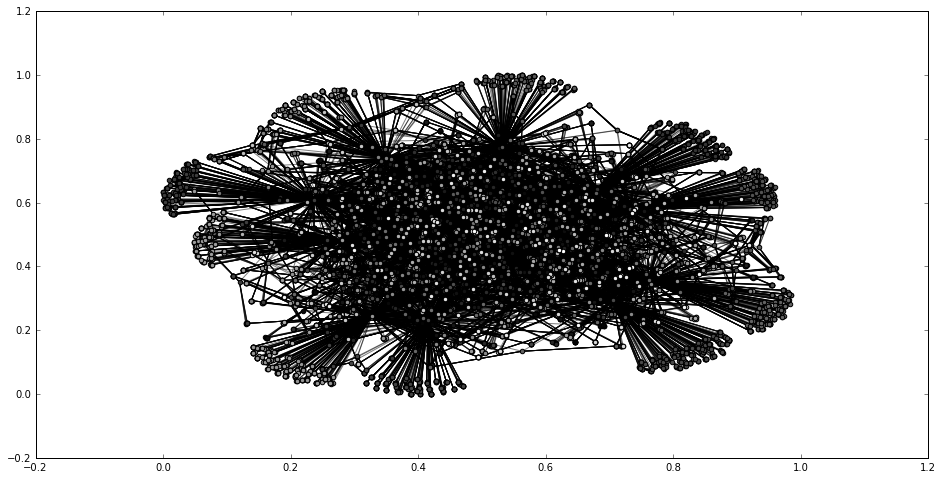

In [18]:
# Set the plot figure size
plt.figure(figsize=(16,8))

# first compute the best partition
partition = community.best_partition(G)
size = float(len(set(partition.values())))
pos = nx.spring_layout(G)
count = 0.
for com in set(partition.values()) :
    count = count + 1.
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]
    nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 20,
                                node_color = str(count / size))

nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()